Rayleigh-Darcy number: 14235.81923076923
dt: 0.36000000000000004, computed dt: 480.7692307692307 critical dt: 3004807692.307692
Completed: 0.0 %
Completed: 10.0 %
Completed: 20.0 %
Completed: 30.0 %
Completed: 40.0 %
Completed: 50.0 %
Completed: 60.0 %
Completed: 70.0 %
Completed: 80.0 %
Completed: 90.0 %
Completed: 100.0 %
Conduction:  1.0
Total simulation time: 1.0001000000000002 hours


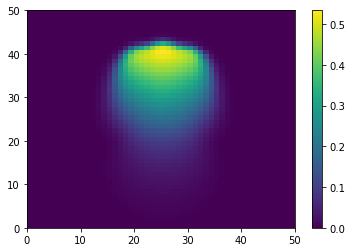

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

# box size, m
w = h = 1
# intervals in x-, y- directions, m
dx = dy = 0.02
# Thermal diffusivity, m2.s-1
alpha = 2.08e-7
# Porosity
n = 0.4
# Viscosity kg/m
mu = 1.00E-03 
# Permeability m2
k = 1E-7
# Thermal expansion 
beta = 8.80E-05
# Cf
cf = 4290
# rhow
rhow = 980
# gravity
g = 9.81 

# Set conduction to 0 to disable
conduction = 1.

# Temperature of the cable
Tcool, Thot = 0, 70

# Cable geometry, inner radius r, width dr centred at (cx,cy) (mm)
r, cx, cy = 0.05, 0.5, 0.5
r2 = r**2

# Cable geometry, inner radius r, width dr centred at (cx,cy) (mm)
cr1, cx1, cy1 = 0.05, 0.5, 0.4
cr1r2 = cr1**2

# Cable geometry, inner radius r, width dr centred at (cx,cy) (mm)
cr2, cx2, cy2 = 0.05, 0.5, 0.6
cr2r2 = cr2**2

# pipe geometry
pr, px, py = 0.2, 0.75, 0.5
pr2 = pr**2
alphaSteel = 11.72e-6 #mm^2/s

# Rayleigh number
ra = (rhow * g * (h -cx) * k * beta * (Thot-Tcool))/(mu*alpha)
print("Rayleigh-Darcy number: {}".format(ra))

# Calculations
nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * alpha * (dx2 + dy2))

dt = 0.0001 * 3600
print("dt: {}, computed dt: {} critical dt: {}".format(dt, dx2 * dy2 / (2 * alpha * (dx2 + dy2)), 1/(2 * alpha * (dx2 + dy2))))

a = alpha * np.ones((nx, ny))
u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

flux = u0.copy()

uu = []


# Initial conditions

for i in range(nx):
    for j in range(ny):
        #mid cable
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot
        # left cable
        p2 = (i*dx-cx1)**2 + (j*dy-cy1)**2
        if p2 < cr1r2:
            u0[i,j] = Thot
        # right cable
        p2 = (i*dx-cx2)**2 + (j*dy-cy2)**2
        if p2 < cr2r2:
            u0[i,j] = Thot
        # Modify pipe alpha
        p2 = (i*dx-px)**2 + (j*dy-py)**2
        if p2 < pr2:
            a[i,j] = alphaSteel
        

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space, upwind solution for convection
    # Convection velocity term:
    # The velocity corresponds to differential density, since we are measuring the differnetial temp,
    # the rho(1 - beta(T)) is written as rho*(beta*DeltaT)
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + \
     + conduction * a[1:-1,1:-1] * dt * ((u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2 + \
          (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2) + \
    dt * (1/(n*mu)*k*g*rhow)*(beta*(u0[1:-1,1:-1]-Tcool)) * \
    (u0[2:,1:-1] - u0[1:-1,1:-1])/(dy)
    
    flux[1:-1,1:-1] = dt * (1/(n*mu)*k*9.81*rhow)*(beta*(u0[1:-1,1:-1]-Tcool)) * \
    (u0[2:,1:-1] - u0[1:-1,1:-1])/(dy)

    for i in range(nx):
        for j in range(ny):
            #mid cable
            p2 = (i*dx-cx)**2 + (j*dy-cy)**2
            if p2 < r2:
                u0[i,j] = Thot
            # left cable
            p2 = (i*dx-cx1)**2 + (j*dy-cy1)**2
            if p2 < cr1r2:
                u0[i,j] = Thot
            # right cable
            p2 = (i*dx-cx2)**2 + (j*dy-cy2)**2
            if p2 < cr2r2:
                u0[i,j] = Thot

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 10001
npercent = int(nsteps/100)
for m in range(nsteps):
    if m % (10*npercent) == 0:
        print("Completed: {} %".format(m/npercent))
    u0, u = do_timestep(u0, u)
    uu.append(u.copy())

print("Conduction: ", conduction)
print("Total simulation time: {} hours".format(dt * nsteps / 3600))

fig = plt.figure()
pcm = plt.pcolormesh(np.flipud(uu[len(uu)-1]))
plt.colorbar()    

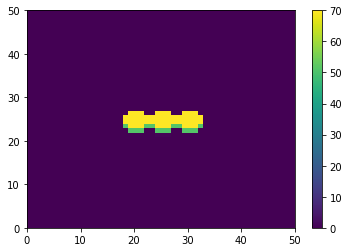

In [4]:
fig = plt.figure()
pcm = plt.pcolormesh(np.flipud(uu[0]))
#plt.xlim(40,160)
#plt.ylim(40,200)
plt.colorbar()    


In [ ]:
def step(i):
    j = int(nsteps/100*i)
    pcm.set_array(np.flipud(uu[j]).ravel())
    plt.draw()

anim = FuncAnimation(fig, step, interval=50)
HTML(anim.to_html5_video())

In [ ]:
fig = plt.figure()
pcm = plt.pcolormesh(np.flipud(uu[10000]))
plt.colorbar()    
#plt.xticks([0,20,40,60,80],[0,100,200,300,400])
#plt.yticks([0,20,40,60,80],[0,100,200,300,400])
print(len(uu))

In [ ]:

fig = plt.figure()
pcm = plt.pcolormesh(uu[len(uu)-1])
plt.colorbar()    

In [ ]:
sum = 0
for i in range(20,80,1):
        if p2 > r2:
            sum += flux[i,20]
print(-sum/0.6)

In [ ]:
0.0019774250706145148*(rhow*cf)/(dt*nsteps)

In [ ]:
xi, yi = np.mgrid[0:1:100j, 0:1:100j]
dy, dx = np.gradient(-u)

In [ ]:
fig, ax = plt.subplots()
ax.streamplot(xi[:,0], yi[0,:], dx, dy, color='0.8', density=1)

In [ ]:
 99531105882.35294 * k